In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from meowmeowbeenz import MAX_RATING, MIN_RATING, RATINGS, MeowRandomRatings

## Build graph

$N$ individuals are represented on a graph $G=(V, E)$ where $V=\{1, \dots, N\}$.

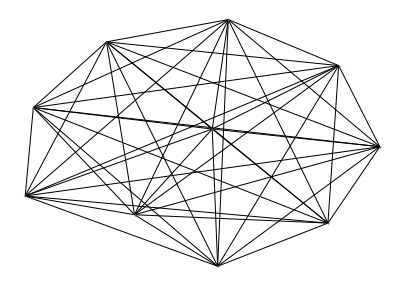

In [3]:
N = 10
G = nx.complete_graph(N)

# save layout
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.axis('off')
plt.show()

## Random rating distribution

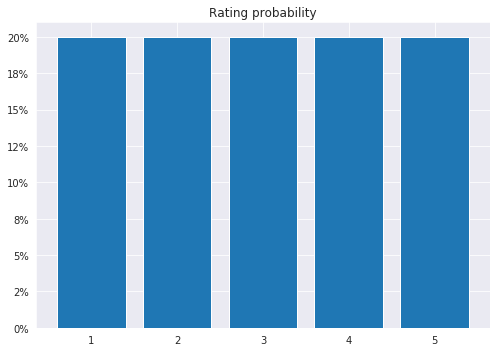

In [4]:
# rating_distr = [1., 2., 3., 5., 4.]
# rating_distr = [1., 1., 1., 1., 10.]
# rating_distr = [10., 1., 1., 1., 1.]
rating_distr = [1., 1., 1., 1., 1.]
rating_distr /= np.sum(rating_distr)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.bar(RATINGS, rating_distr)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.set_title('Rating probability')
    plt.tight_layout()
    plt.show()

### Models

Let $X^i_t$ the aggregated rating of node $i$ at time $t$.
We model the rating times as a Poisson point process $(N_t)_{t\in\mathbb{N}}$ taking values in the set of edges $E$. Let $(\tau_k)_{k\in\mathbb{N}}$ the sequence of jump times. We write $R^k_{i, j}\in\{1, 2, 3, 4, 5\}$ the instantaneous rating given at time $\tau_k$ (indices $i$ and $j$ are superfluous but helpful for readabiliy).

Informally, if $N_{\tau_k} = (i, j)$, this means that at random times one individual $j$ is picked at random and rates another individual $i$ with whom it is connected.

Let $I^k_{i, j} = \mathbb{1}_{\tau_k = (i, j)}$. We assume the following dynamic on the ratings:

$$
X^i_t = \frac{\sum_{k : \tau_k \leq t} \sum_{j\in \mathcal{N}(i)} I^k_{i, j} W^k_{i, j} R^k_{i, j}}{\sum_{k : \tau_k \leq t} \sum_{j\in \mathcal{N}(i)} I^k_{i, j} W^k_{i, j}}
$$

that is the aggregated rating of individual $i$ is the weighted sum of past ratings. Note that $(X_t)$ is typically *not* a Markov chain but, under reasonable measurability conditions on the weights, $(X_t, w_t)$ is. #

In what follows, we will ignore the continuous time aspect and focus on the embedding discrete chain. 

We first study three models for the weights.

* **Giver influence**: $W^k_{i, j} = X^j_{\tau_k}$. The higher rated the giver, the more impactful the feedback.
* **Receiver attractive**: $W^k_{i, j} = \frac{\alpha}{1 + \lvert X^i_{\tau_k^-} - R^k_{i, j} \rvert^p} + (1-\alpha) X^j_{\tau_k}$, $\alpha\in[0, 1], p>0$. The weight is a combination of the rating of the giver and the difference between the incoming rating and the current aggregate: the wider the spread, the smaller the weight. Typically, a $1$ given to a $5$-rated individual has a small impact in this model.
* **Receiver repulsive**: $W^k_{i, j} = \alpha\lvert X^i_{\tau_k^-} - R^k_{i, j} \rvert^p + (1-\alpha) X^j_{\tau_k}$, $\alpha\in[0, 1], p>0$. The weight is a combination of the rating of the giver and the difference between the incoming rating and the current aggregate: the wider the spread, the larger the weight. Typically, a $1$ given to a $5$-rated individual has a large impact in this model.

For now, we consider i.i.d sequences of ratings $R^k_{i, j}$ drawn from an initial distribution $\nu_0$. Later, we will investigate dynamics where individuals adapt their ratings. Additionally, we can add a forgetting mechanism in the form of a buffer size $B$: when individual $i$ has received more than $B$ ratings, the first ones are discarded to make room for the more recent feedback.

In [5]:
model = MeowRandomRatings(G, rating_distr)

T = int(5e3)
BUFFER_SIZE = 50
x0 = np.mean(RATINGS) * np.ones(N)
x0[-1] = MAX_RATING
x0[:-1] = MIN_RATING

model.simulate(T, x0, buffer_size=BUFFER_SIZE, mode='giver_influence', verbose=True)
ratings_giver_influence = model.ratings
X_giver_influence = model.X
best_giver_influence = model.best
worst_giver_influence = model.worst
ratings_giver_influence_best = model.ratings_best 
ratings_giver_influence_worst = model.ratings_worst 

model.simulate(T, x0, buffer_size=BUFFER_SIZE, mode='receiver_attractive', params={'alpha': 1.0, 'exponent': 1.0}, verbose=True)
ratings_receiver_attractive = model.ratings
X_receiver_attractive = model.X
best_receiver_attractive = model.best
worst_receiver_attractive = model.worst
ratings_receiver_attractive_best = model.ratings_best 
ratings_receiver_attractive_worst = model.ratings_worst 

model.simulate(T, x0, buffer_size=BUFFER_SIZE, mode='receiver_repulsive', params={'alpha': 1.0, 'exponent': 1.0}, verbose=True)
ratings_receiver_repulsive = model.ratings
X_receiver_repulsive = model.X
best_receiver_repulsive = model.best
worst_receiver_repulsive = model.worst
ratings_receiver_repulsive_best = model.ratings_best 
ratings_receiver_repulsive_worst = model.ratings_worst 

100%|██████████| 5000/5000 [00:01<00:00, 4884.55it/s]


### Rating dynamic

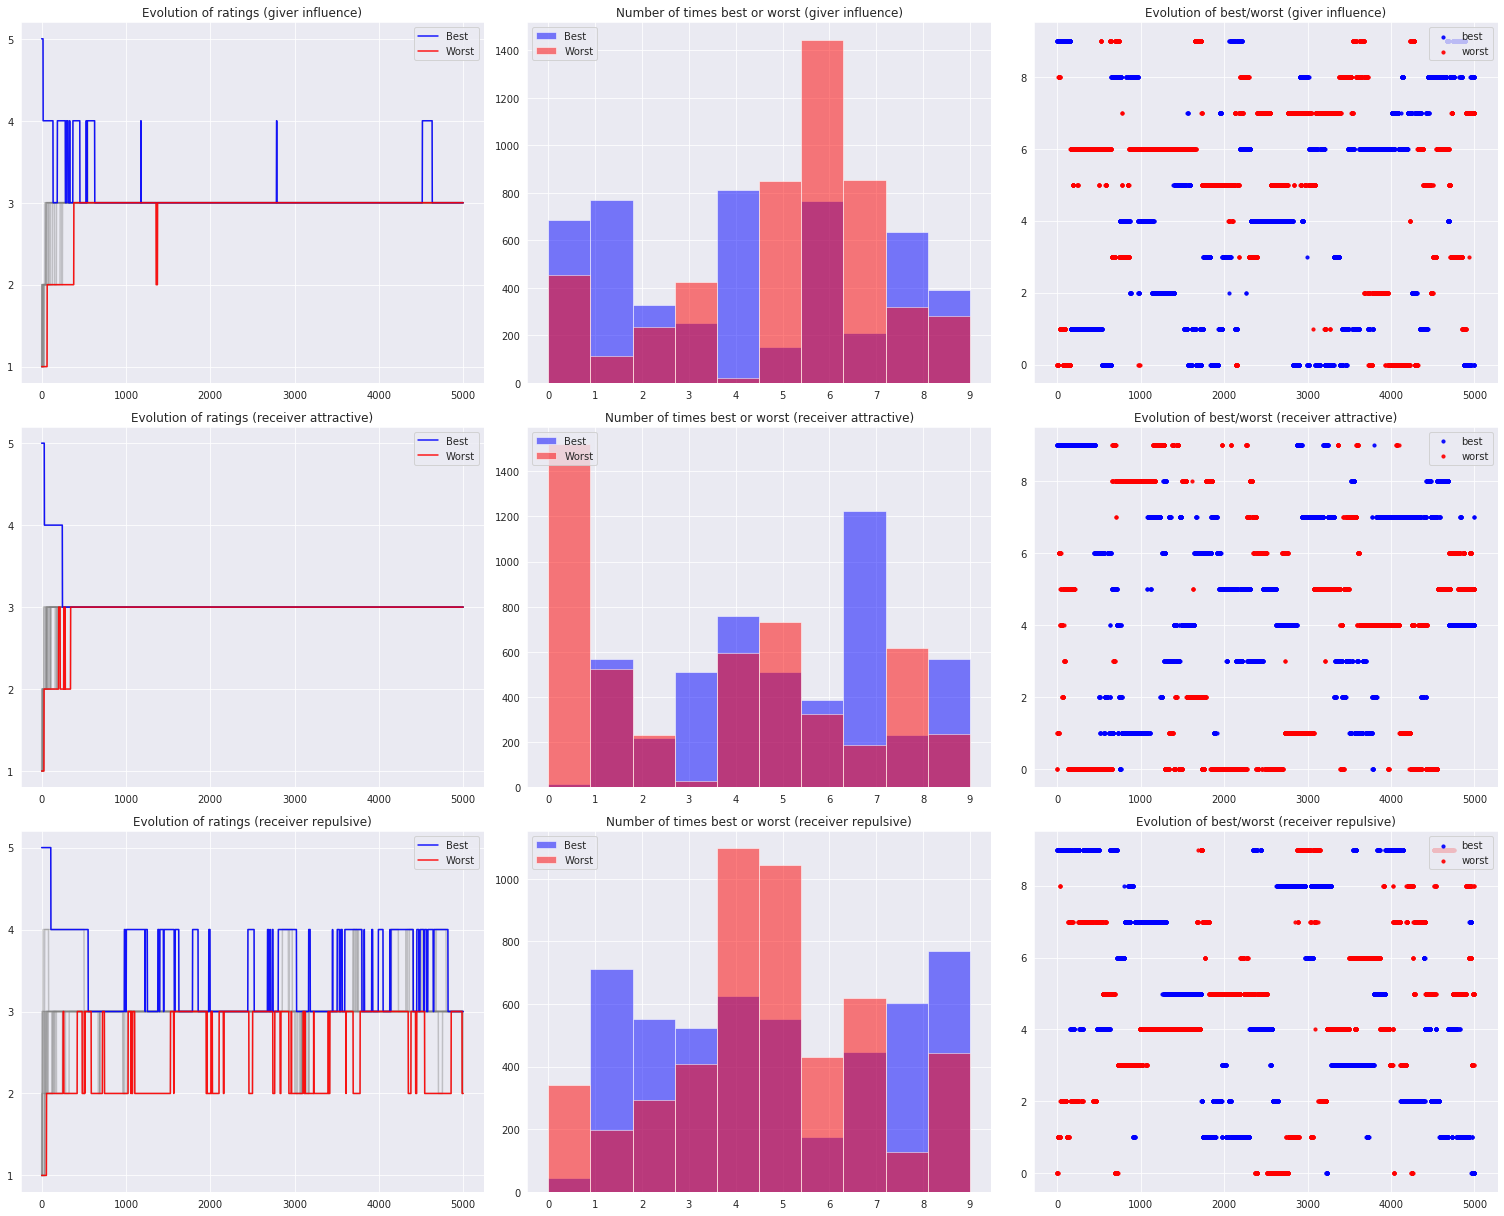

In [6]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(21, 17), nrows=3, ncols=3)
    
    ax = axes[0, 0]
    ax.plot(ratings_giver_influence, color='grey', alpha=0.4)
    ax.plot(ratings_giver_influence_best, color='blue', label='Best', alpha=0.9)
    ax.plot(ratings_giver_influence_worst, color='red', label='Worst', alpha=0.9)
    ax.legend(loc='upper right')
    ax.set_title('Evolution of ratings (giver influence)')
    ax.set_yticks(RATINGS)
    
    ax = axes[0, 1]
    ax.hist(best_giver_influence, color='blue', label='Best', alpha=0.5)
    ax.hist(worst_giver_influence, color='red', label='Worst', alpha=0.5)
    ax.legend(loc='upper left')
    ax.set_title('Number of times best or worst (giver influence)')
    ax.set_xticks(range(N))
    
    ax = axes[0, 2]
    ax.scatter(range(T + 1), best_giver_influence, label='best', color='blue', alpha=0.9, s=10)
    ax.scatter(range(T + 1), worst_giver_influence, label='worst', color='red', alpha=0.9, s=10)
    ax.legend(loc='upper right')
    ax.set_title('Evolution of best/worst (giver influence)')
    
    ax = axes[1, 0]
    ax.plot(ratings_receiver_attractive, color='grey', alpha=0.4)
    ax.plot(ratings_receiver_attractive_best, color='blue', label='Best', alpha=0.9)
    ax.plot(ratings_receiver_attractive_worst, color='red', label='Worst', alpha=0.9)
    ax.legend(loc='upper right')
    ax.set_title('Evolution of ratings (receiver attractive)')
    ax.set_yticks(RATINGS)
    
    ax = axes[1, 1]
    ax.hist(best_receiver_attractive, color='blue', label='Best', alpha=0.5)
    ax.hist(worst_receiver_attractive, color='red', label='Worst', alpha=0.5)
    ax.legend(loc='upper left')
    ax.set_title('Number of times best or worst (receiver attractive)')
    ax.set_xticks(range(N))
    
    ax = axes[1, 2]
    ax.scatter(range(T + 1), best_receiver_attractive, label='best', color='blue', alpha=0.9, s=10)
    ax.scatter(range(T + 1), worst_receiver_attractive, label='worst', color='red', alpha=0.9, s=10)
    ax.legend(loc='upper right')
    ax.set_title('Evolution of best/worst (receiver attractive)')
    
    ax = axes[2, 0]
    ax.plot(ratings_receiver_repulsive, color='grey', alpha=0.4)
    ax.plot(ratings_receiver_repulsive_best, color='blue', label='Best', alpha=0.9)
    ax.plot(ratings_receiver_repulsive_worst, color='red', label='Worst', alpha=0.9)
    ax.legend(loc='upper right')
    ax.set_title('Evolution of ratings (receiver repulsive)')
    ax.set_yticks(RATINGS)
    
    ax = axes[2, 1]
    ax.hist(best_receiver_repulsive, color='blue', label='Best', alpha=0.5)
    ax.hist(worst_receiver_repulsive, color='red', label='Worst', alpha=0.5)
    ax.legend(loc='upper left')
    ax.set_title('Number of times best or worst (receiver repulsive)')
    ax.set_xticks(range(N))
    
    ax = axes[2, 2]
    ax.scatter(range(T + 1), best_receiver_repulsive, label='best', color='blue', alpha=0.9, s=10)
    ax.scatter(range(T + 1), worst_receiver_repulsive, label='worst', color='red', alpha=0.9, s=10)
    ax.legend(loc='upper right')
    ax.set_title('Evolution of best/worst (receiver repulsive)')
    
    plt.tight_layout()
    plt.show()

### Zoom on a single node

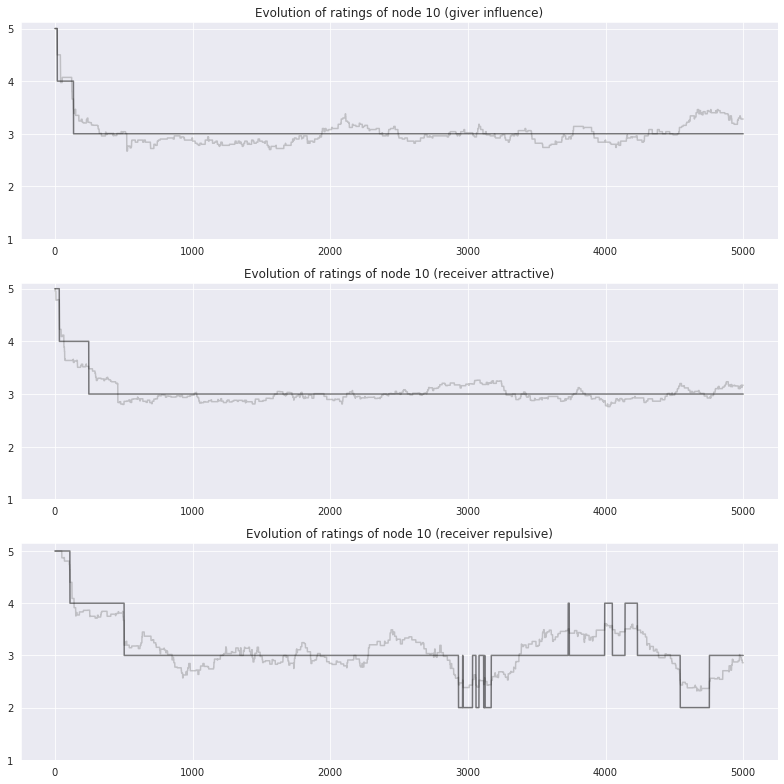

In [7]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(11, 11), nrows=3, ncols=1)
    
    node = -1
    
    ax = axes[0]
    ax.plot(X_giver_influence[:, node], color='grey', alpha=0.4)
    ax.plot(ratings_giver_influence[:, node], color='black', alpha=0.5)
    ax.set_yticks(RATINGS)
    ax.set_title('Evolution of ratings of node {} (giver influence)'.format(node % N + 1))

    ax = axes[1]
    ax.plot(X_receiver_attractive[:, node], color='grey', alpha=0.4)
    ax.plot(ratings_receiver_attractive[:, node], color='black', alpha=0.5)
    ax.set_yticks(RATINGS)
    ax.set_title('Evolution of ratings of node {} (receiver attractive)'.format(node % N + 1))
    
    ax = axes[2]
    ax.plot(X_receiver_repulsive[:, node], color='grey', alpha=0.4)
    ax.plot(ratings_receiver_repulsive[:, node], color='black', alpha=0.5)
    ax.set_yticks(RATINGS)
    ax.set_title('Evolution of ratings of node {} (receiver repulsive)'.format(node % N + 1))
    
    plt.tight_layout()
    plt.show()